In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from helper_funcs import conv2d_output_shape, MaxPool2d_output_shape

In [2]:
trainset = datasets.MNIST(root='./data', train=True, download=False, transform = transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=False, transform = transforms.ToTensor())

In [3]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [4]:
images, labels = next(iter(trainloader))

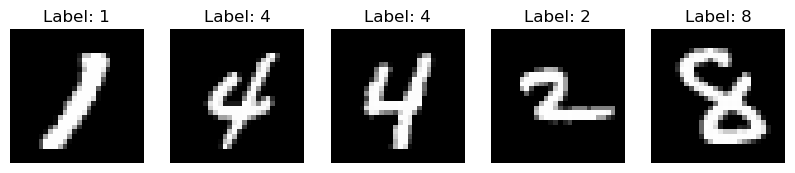

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for idx in range(5):
    img_tensor = images[idx]
    label = labels[idx].item()

    img_np = img_tensor.squeeze().numpy()

    axes[idx].imshow(img_np, cmap='gray')
    axes[idx].set_title(f"Label: {label}")
    axes[idx].axis("off")
plt.show()

In [12]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(32*7*7,256),
            nn.Tanh()
        )
        self.output_layer = nn.Linear(256, 10)
        
    def forward(self, x):
         B,C,W,H = x.shape
         assert C == 1 and W == 28 and H == 28, 'input tensor should be of dimension B*1*28*28'
         x = self.conv1(x)
         x = self.conv2(x)
         x = x.view(B,-1)
         x = self.linear_layer(x)
         x = self.output_layer(x)
         return x

In [17]:
model = BaseModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [18]:
num_epochs = 5
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    model.train()
    current_loss = 0.0
    for img_tensor, label in trainloader:
        output = model(img_tensor)
        
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
    avg_train_loss = current_loss / len(trainloader)
    train_loss.append(avg_train_loss)
   
    model.eval()
    current_loss = 0.0
    with torch.no_grad():
        for img_tensor, label in testloader:
            output = model(img_tensor)
            loss = criterion(output, label)
            current_loss += loss.item()
    avg_test_loss = current_loss / len(testloader)
    test_loss.append(avg_test_loss)
    if (epoch % 5) == 0:
        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.3f}; Test Loss {avg_test_loss:.3f}")


Epoch 1: Train Loss 0.170; Test Loss 0.082


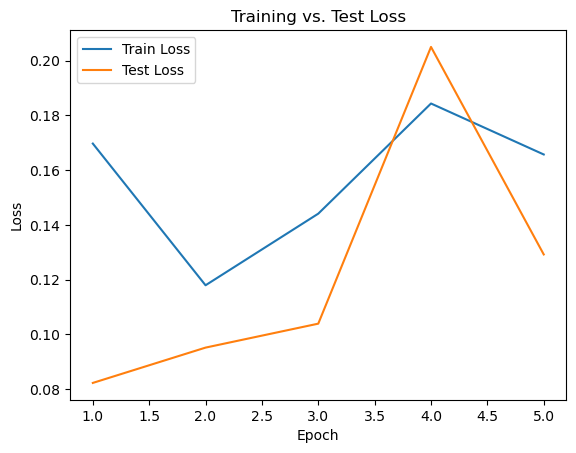

In [19]:
plt.plot(range(1, num_epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Test Loss")
plt.show()